In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import umap as umap

import scanpy as sc
import anndata

## scATAC-Seq
Using **ChromVAR** to calculate the k-mer z-score matrix from **scATAC-Seq** data. Use the feature matrix of z-score for trajectory inference.

In [2]:
scATAC_tfscore = pd.read_csv("./scATAC_tfscore.csv", sep = ",", index_col = 0)
scATAC_tfscore.head()

,ENSG00000008196_LINE2_TFAP2B_D_N1,ENSG00000008196_LINE3_TFAP2B_D_N1,ENSG00000008196_LINE4_TFAP2B_D_N1,ENSG00000008196_LINE5_TFAP2B_D_N1,ENSG00000008197_LINE6_TFAP2D_D,ENSG00000087510_LINE7_TFAP2C_D_N3,ENSG00000087510_LINE12_TFAP2C_D_N2,ENSG00000087510_LINE13_TFAP2C_D_N2,ENSG00000087510_LINE14_TFAP2C_D_N2,ENSG00000087510_LINE8_TFAP2C_D_N1,...,ENSG00000120693_LINE19389_SMAD9_I_N1,ENSG00000120693_LINE19390_SMAD9_I_N1,ENSG00000120693_LINE19391_SMAD9_I_N1,ENSG00000120693_LINE19392_SMAD9_I_N1,ENSG00000110693_LINE19574_SOX6_I_N7,ENSG00000110693_LINE19569_SOX6_I_N1,ENSG00000112837_LINE19949_TBX18_I_N1,ENSG00000112837_LINE19950_TBX18_I_N1,ENSG00000122145_LINE20002_TBX22_I_N1,ENSG00000122145_LINE20003_TBX22_I_N1
cellname,,,,,,,,,,,,,,,,,,,,,
singles-BM0828-HSC-fresh-151027-1,-0.84034,0.40744,-1.20670,0.489410,-0.87663,-0.47600,-0.751300,0.22765,-1.50740,0.698450,...,0.020046,-0.63593,-1.31980,-0.16264,-1.71410,0.470720,0.74096,-0.035966,0.74096,-0.035966
singles-BM0828-HSC-fresh-151027-2,-0.29338,-0.60210,0.47999,0.736140,0.46593,0.53029,-0.131590,-1.89470,0.69155,-0.239230,...,0.285160,-1.49380,-1.30080,-2.45210,-1.38670,0.043402,-1.00480,2.089800,-1.00480,2.089800
singles-BM0828-HSC-fresh-151027-3,-2.26680,0.29362,-1.45240,-0.079287,0.53485,-1.50400,-2.048600,-0.21798,-1.51760,-1.397400,...,-0.429310,0.11038,-0.61102,-0.85499,0.16768,-0.543430,-0.29345,0.072564,-0.29345,0.072564
singles-BM0828-HSC-fresh-151027-4,-0.85146,-1.51830,-2.08720,-0.395140,-1.00440,-1.42200,-0.708890,-1.93880,-1.84100,-0.428110,...,-0.511970,-2.08480,-1.61230,-0.61207,1.28240,0.765460,-0.63118,-0.643090,-0.63118,-0.643090
singles-BM0828-HSC-fresh-151027-5,0.69698,0.73263,0.48880,0.250660,0.29524,-0.85568,0.002218,0.65011,0.78933,0.032639,...,1.216000,-0.50780,-0.56950,-2.10040,-0.17399,-0.244760,-1.91350,-1.048500,-1.91350,-1.048500


In [3]:
celltypes_atac = []
with open("scATAC_celltype.txt", "r") as fp:
    for line in fp:
        celltypes_atac.append(line.strip("\n"))

celltypes_atac = np.array(celltypes_atac)

In [4]:
neg_index = np.concatenate((np.where(celltypes_atac == "pDC")[0], np.where(celltypes_atac == "Mono")[0], np.where(celltypes_atac == "UNK")[0]))
indices = np.ones((2034,))
indices[neg_index] = 0
indices = (indices == 1)
scATAC = scATAC_tfscore.iloc[indices,:]
celltypes_atac = celltypes_atac[indices]
celltypes_atac[np.concatenate((np.where(celltypes_atac == "GMP1low")[0], np.where(celltypes_atac == "GMP2mid")[0], np.where(celltypes_atac == "GMP3high")[0]))] = "GMP"

In [5]:
umap_op = umap.UMAP(n_components=2, n_neighbors = 5)
x_umap = umap_op.fit_transform(scATAC.values)

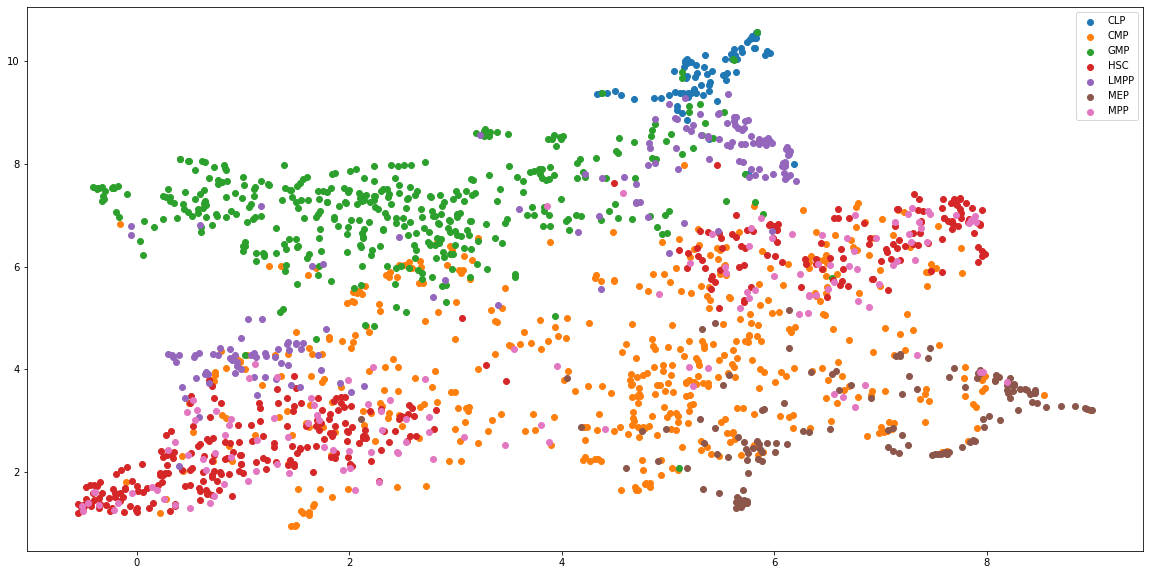

In [6]:
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_atac):
    ax.scatter(x_umap[np.where(celltypes_atac == cluster)[0],0], x_umap[np.where(celltypes_atac == cluster)[0],1], label = cluster)

ax.legend()

In [7]:
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scATAC.values)

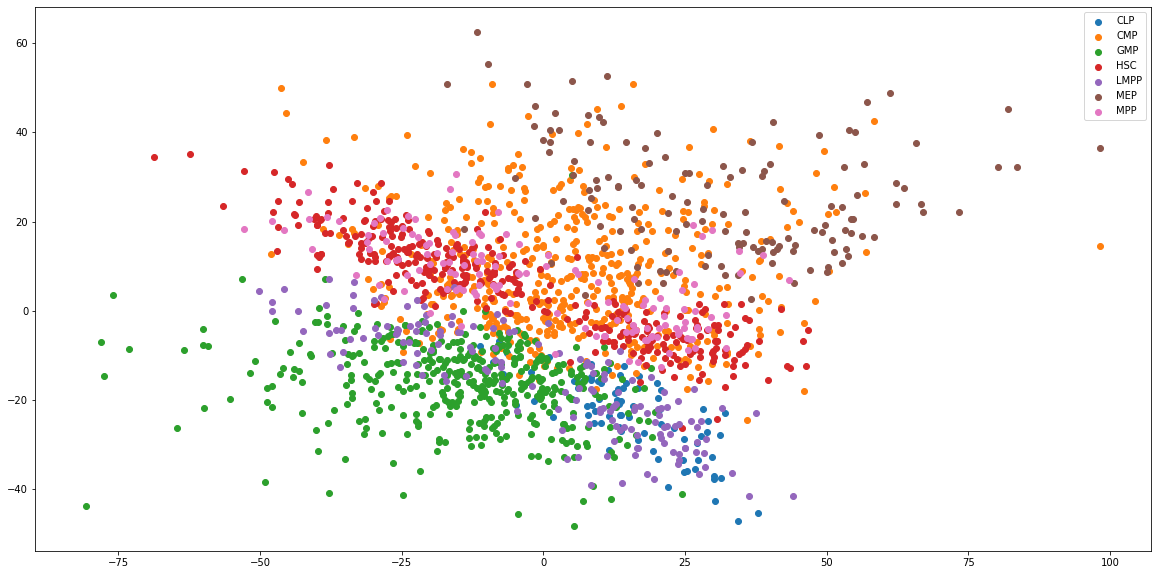

In [8]:
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_atac):
    ax.scatter(x_pca[np.where(celltypes_atac == cluster)[0],0], x_pca[np.where(celltypes_atac == cluster)[0],1], label = cluster)

ax.legend()

## scRNA-Seq

In [9]:
scRNA = pd.read_csv("./scRNA_500gs.csv", index_col= 0).iloc[::3,:]
scRNA.head()

,ABI2,ABO,ACAA1,ACBD3,ACSS1,ACTB,ACTG1,ADA,ADAM28,ADCY7,...,ZDHHC9,ZFAND2B,ZFAND5,ZMYND11,ZNF362,ZNF638,ZNF711,ZNF720,ZNF785,ZRANB2
AACAAATG-GGTCCCTT,0.000000,0.0,0.260277,0.0,0.0,1.750351,1.938135,0.0,0.783516,0.0,...,0.000000,0.000000,0.910854,0.260277,0.0,0.000000,0.0,0.0,0.260277,0.466609
AGCACGTA-CCATTACT,0.000000,0.0,0.000000,0.0,0.0,0.675427,1.580933,0.0,0.675427,0.0,...,0.675427,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.074915,0.000000
AGCTTCGA-AACAATCC,1.541471,0.0,0.000000,0.0,0.0,1.042299,1.042299,0.0,0.000000,0.0,...,0.000000,1.042299,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000
GTCTTCCT-CCCTAACC,0.000000,0.0,0.000000,0.0,0.0,0.685911,0.685911,0.0,0.000000,0.0,...,0.000000,0.000000,0.685911,0.000000,0.0,1.375421,0.0,0.0,0.000000,0.000000
ACCAAGGG-TGCCTCAC,0.000000,0.0,0.000000,0.0,0.0,1.551862,1.785127,0.0,0.000000,0.0,...,0.000000,0.000000,0.806514,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [10]:
celltypes_rna = []
with open("scRNA_celltype.txt", "r") as fp:
    for line in fp:
        celltypes_rna.append(line.strip("\n"))

celltypes_rna = np.array(celltypes_rna)[::3]
celltypes_rna = np.where(celltypes_rna == "PreB_NK", "CLP", celltypes_rna)
celltypes_rna = np.where(celltypes_rna == "MLP", "LMPP", celltypes_rna)

In [11]:
umap_op = umap.UMAP(n_components=2, n_neighbors = 5)
x_umap = umap_op.fit_transform(scRNA.values)

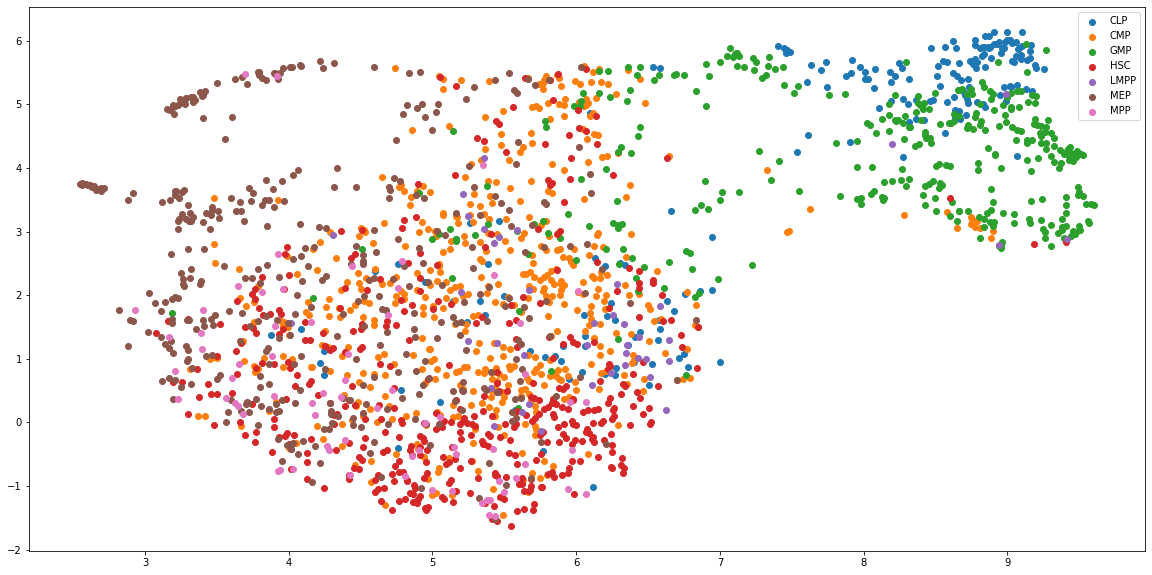

In [12]:
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_rna):
    ax.scatter(x_umap[np.where(celltypes_rna == cluster)[0],0], x_umap[np.where(celltypes_rna == cluster)[0],1], label = cluster)

ax.legend()

In [13]:
pca_op = PCA(n_components = 2)
x_pca = pca_op.fit_transform(scRNA.values)

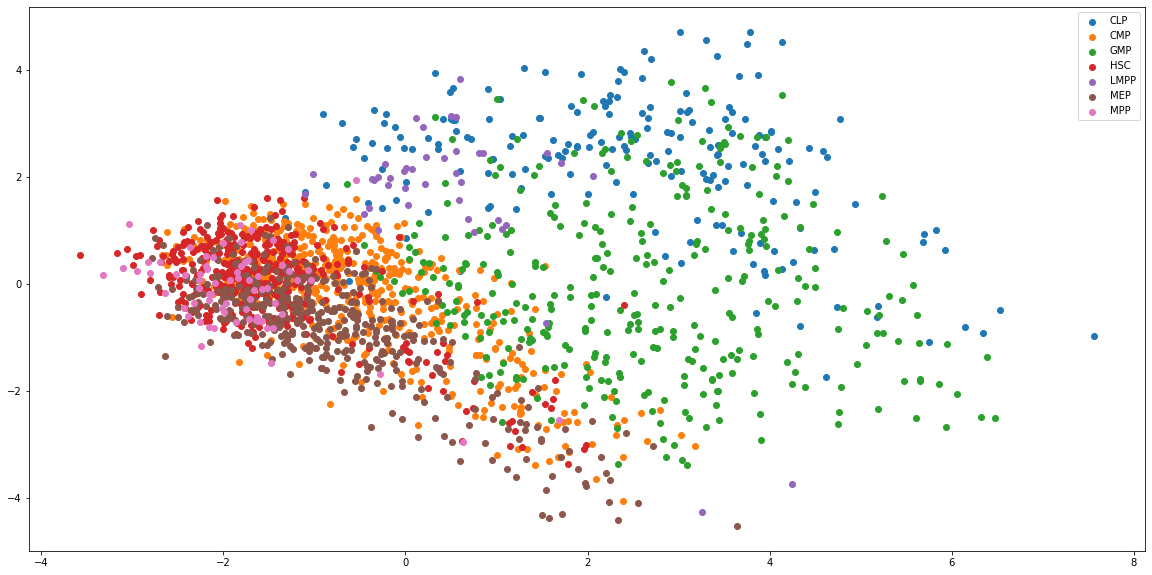

In [14]:
fig = plt.figure(figsize = (20,10))
ax = fig.subplots(1)
for cluster in np.unique(celltypes_rna):
    ax.scatter(x_pca[np.where(celltypes_rna == cluster)[0],0], x_pca[np.where(celltypes_rna == cluster)[0],1], label = cluster)

ax.legend()

In [15]:
processed = "./processed/"
with open(processed + "celltypes_atac.txt", "w") as fp:
    for cluster in celltypes_atac:
        fp.write(cluster + "\n")

with open(processed + "celltypes_rna.txt", "w") as fp:
    for cluster in celltypes_rna:
        fp.write(cluster + "\n")

scRNA.to_csv(processed + "count_rna.csv")
scATAC.to_csv(processed + "count_atac.csv")